In [1]:
%matplotlib inline
import os
import gc
import pickle
import pandas as pd
import numpy as np
import sys
from os import listdir
from os.path import isfile, join
from keras.models import Model, Sequential
from keras.layers import LSTM, Dense, Embedding
from keras.utils import multi_gpu_model
from sklearn.metrics import precision_recall_fscore_support as score
import multiprocessing
from joblib import Parallel, delayed
from matplotlib import pyplot as plt

path                 = "."

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [3]:
# FIX 1 of 3 : set the following vars
path                 = "." #path to dir where test pickles reside and h5 file is
modelfingerprint     = "kubernetes_train_[80-20]_giga_long_mltithrdedgentr_PikTranSav_Mdl_[J_Filternet_tstep1]_epch_75_kube_binar_crsentr_adm_binar_acc.py" # name of py file
modelweightsfilename = "kubernetes_train_[80-20]_giga_long_mltithrdedgentr_PikTranSav_Mdl_[J_Filternet_tstep1]_epch_75_kube_binar_crsentr_adm_binar_acc.h5" # name of h5 file

# FIX 2 of 3: update the input_length as per timesteps
input_length    = 1 # 1 or 2                        # X_final.shape[1]
input_dim       = 3541                              # X_final.shape[2]
output_dim      = 1

pickgpus = "0,1,2,3,4,5,6,7"
os.environ["CUDA_VISIBLE_DEVICES"] = pickgpus

def create_model(input_dim, input_length, output_dim):
    print ('Creating model...')
    # FIX 3 of 3: copy everything from here till 'return parallel_model'
    model = Sequential()
    model.add(LSTM(2000, input_shape=(input_length,input_dim),return_sequences=True))
    model.add(LSTM(2000, input_shape=(input_length,input_dim),return_sequences=True))
    model.add(LSTM(1000, input_shape=(input_length,input_dim),return_sequences=True))
    model.add(LSTM(2000, input_shape=(input_length,input_dim),return_sequences=True))
    model.add(LSTM(2000))
    model.add(Dense(output_dim, activation='sigmoid'))
    ###
    print('Initiating parallel GPU model')
    parallel_model = multi_gpu_model(model, gpus=1+pickgpus.count(","))
    print ('Compiling...')
    parallel_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_accuracy'])
    return parallel_model

In [ ]:
# STEP 1
model   = create_model(input_dim, input_length, output_dim)
# STEP 2
print('Loading Model weights before Testing')
model.load_weights( join(path, modelweightsfilename) )

In [ ]:
# warm up
warmup=True

In [ ]:
test_files = [f for f in listdir(path) if isfile(join(path, f))]
test_files = [x for x in test_files if 'dict_jobID_' in x and 'FROM_giga_takeoutdf_w_jobgroup.pickle' in x ]
test_files.sort()

In [ ]:
import itertools

def chunked(it, size):
    it = iter(it)
    while True:
        p = tuple(itertools.islice(it, size))
        if not p:
            break
        yield p

In [ ]:
# parameters
from threading import Lock
lock               = Lock()

def h(jobID_Xtest_Ytest):
    global model
    global lock
    
    Y_true = []
    Y_pred = []
    jobID, X_test, Y_test     = jobID_Xtest_Ytest[0], jobID_Xtest_Ytest[1][0], jobID_Xtest_Ytest[1][1]         
    try:
        lock.acquire()
        y_pred_this_file = model.predict(X_test)
    finally:
        lock.release()
    
    Y_pred.extend([ np.rint(jj[0]) for jj in y_pred_this_file ])
    Y_true.extend([ xj[0] for xj in Y_test ])
    
    #test 1
    if not all(x == Y_true[0] for x in Y_true):
        print('All Y_true labels for jobID %d are not same \n' % jobID)
    
    return [jobID, Y_true, Y_pred]

In [ ]:
stage_results = []
import random

for k in range(len(test_files)):
    # Load { jobID -> X_test, Y_test }:
    print( "Loading test file #%d - %s" % (k, test_files[k]) )
    with open( join(path, test_files[k]) , 'rb' ) as handle:
        global_dict = pickle.load(handle)
    print( "Loaded test file #%d" % (len(global_dict))       )
    
    # warm up
    if(warmup):
        print(model.predict(random.choice(list(global_dict.items()))[1][0]))
        warmup=False
        
    start = 1
    for chunk in chunked(global_dict.items(), 48*5):
        print("New Batch started : %d to %d " % (start, start+len(chunk)-1))
        results = Parallel(n_jobs=48, verbose=1, backend="threading")(map(delayed(h), [x for x in chunk] ))
        stage_results.extend(results)
        del results
        start += len(chunk)
    del global_dict
    gc.collect()

In [ ]:
len(stage_results)

with open('stage_results_list_of_jobid_x_y_test.pickle', 'wb') as handle:
    pickle.dump(stage_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Load predicted 'heartbeat' level results into memory

In [4]:
with open('stage_results_list_of_jobid_x_y_test.pickle', 'rb') as handle:
    stage_results = pickle.load(handle)

In [21]:
stage_results[0]

[33751041, [0, 0, 0, 0, 0, 0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]]

In [5]:
def process(listelement_parameters):
    listelement = listelement_parameters[0]
    parameters  = listelement_parameters[1]
    
    # each input: listelement is [jobID, Y_true, Y_pred]
    # make job level prediction, based on parameters
    decision_threshold = parameters[0]
    minsamplestopick   = parameters[1]
    maxsamplestopick   = parameters[2]
    
    ###
    jobID  = listelement[0]
    Y_true = listelement[1]
    Y_pred = listelement[2]
    
    truelabel = Y_true[0]
    
    # perform job-level prediction in a while loop:
    firstN           = min( minsamplestopick, len(Y_pred) )
    localsamplefrac  = (firstN*1.0) / len(Y_pred)
    localsamplefracN = localsamplefrac
    predictedlabel   = -1
    
    ##### Method: take majority
    while predictedlabel == -1 and firstN <= min(maxsamplestopick, len(Y_pred)):
        #
        localsamplefrac = (firstN*1.0) / len(Y_pred)
        
        ############################################################
        take            = Y_pred[:firstN]
        ############################################################
        
        if take.count(1.0) > int(decision_threshold * len(take)):
            predictedlabel = 1
            break
            
        if take.count(0.0) > int(decision_threshold * len(take)):
            predictedlabel = 0
            break
        
        firstN          =  firstN + 1
    
    # create a python list that will be return
    
    totaljobduration   = 1.0
    predictionduration = -1.0
    return [jobID, totaljobduration, predictionduration, 
            localsamplefrac, len(Y_true), decision_threshold, 
            truelabel, predictedlabel]

    ###################################

# Set parameters 1

In [6]:
%%time
# parameters   = [ decision_threshold, minsamplestopick, maxsamplestopick ]
parameters     = [ 0.95              , 3               ,20]
inputList      = [ [x, parameters] for x in stage_results ]
global_results = Parallel(n_jobs=48*100, verbose=1, backend="threading")(map(delayed(process), inputList))

[Parallel(n_jobs=4800)]: Done 1650 tasks      | elapsed:    1.2s
[Parallel(n_jobs=4800)]: Done 3200 tasks      | elapsed:    1.5s
[Parallel(n_jobs=4800)]: Done 4850 tasks      | elapsed:    1.8s
[Parallel(n_jobs=4800)]: Done 6600 tasks      | elapsed:    2.2s
[Parallel(n_jobs=4800)]: Done 8450 tasks      | elapsed:    2.5s
[Parallel(n_jobs=4800)]: Done 10400 tasks      | elapsed:    2.9s
[Parallel(n_jobs=4800)]: Done 12450 tasks      | elapsed:    3.3s
[Parallel(n_jobs=4800)]: Done 14600 tasks      | elapsed:    3.8s
[Parallel(n_jobs=4800)]: Done 16850 tasks      | elapsed:    4.3s
[Parallel(n_jobs=4800)]: Done 19200 tasks      | elapsed:    4.7s
[Parallel(n_jobs=4800)]: Done 21650 tasks      | elapsed:    5.3s
[Parallel(n_jobs=4800)]: Done 24200 tasks      | elapsed:    6.1s
[Parallel(n_jobs=4800)]: Done 26850 tasks      | elapsed:    7.8s
[Parallel(n_jobs=4800)]: Done 29600 tasks      | elapsed:    8.3s
[Parallel(n_jobs=4800)]: Done 32450 tasks      | elapsed:    9.0s
[Parallel(n_job

CPU times: user 1min 38s, sys: 2min 9s, total: 3min 48s
Wall time: 2min 5s


In [7]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

In [8]:
# Populate totalduration and predictionduration
with open('giga_takeoutdf_w_jobgroup.pickle', 'rb') as f:
    takeoutdf = pickle.load(f)

In [9]:
def fill_durations(row):
    # Input format:
    # [jobID, totaljobduration, predictionduration,localsamplefrac, len(Y_true), decision_threshold,truelabel, predictedlabel]
    
    jobID      = row[0]
    firstN     = int(row[3]*row[4])

    # Sort by timestamp
    getsamples = takeoutdf[takeoutdf.JobID == jobID]
    df         = getsamples.sort_values(by=['HeartBeatTime']) #not inplace
    hlist      = df['HeartBeatTime'].tolist()
    
    starttime     = hlist[0]
    predictedtime = hlist[firstN-1]
    endtime       = hlist[row[4]-1]
    
    row[1]= (endtime-starttime).total_seconds()       #totaljobduration
    row[2]= (predictedtime-starttime).total_seconds() #predictionduration
    
    return jobID

In [10]:
# update times in the results
collector = Parallel(n_jobs=48*5, verbose=1, backend="threading")(map(delayed(fill_durations), global_results ))

[Parallel(n_jobs=240)]: Done 320 tasks      | elapsed:    3.5s
[Parallel(n_jobs=240)]: Done 770 tasks      | elapsed:    4.5s
[Parallel(n_jobs=240)]: Done 1320 tasks      | elapsed:    6.7s
[Parallel(n_jobs=240)]: Done 1970 tasks      | elapsed:    8.1s
[Parallel(n_jobs=240)]: Done 2720 tasks      | elapsed:    9.7s
[Parallel(n_jobs=240)]: Done 3570 tasks      | elapsed:   12.2s
[Parallel(n_jobs=240)]: Done 4520 tasks      | elapsed:   14.2s
[Parallel(n_jobs=240)]: Done 5570 tasks      | elapsed:   16.3s
[Parallel(n_jobs=240)]: Done 6720 tasks      | elapsed:   18.7s
[Parallel(n_jobs=240)]: Done 7970 tasks      | elapsed:   21.4s
[Parallel(n_jobs=240)]: Done 9320 tasks      | elapsed:   24.3s
[Parallel(n_jobs=240)]: Done 10770 tasks      | elapsed:   27.3s
[Parallel(n_jobs=240)]: Done 12320 tasks      | elapsed:   30.6s
[Parallel(n_jobs=240)]: Done 13970 tasks      | elapsed:   34.1s
[Parallel(n_jobs=240)]: Done 15720 tasks      | elapsed:   37.8s
[Parallel(n_jobs=240)]: Done 17570 tas

In [11]:
# Process results:

Y_true_job      = []
Y_predicted_job = []
averagefrac     = []
nodecision      = []
averagetime     = []
totaltestsamples= 0

for r in global_results:
    ###
    totaltestsamples += r[4]
    ###
    
    if r[-1] != -1:
        Y_true_job.append(r[-2])
        Y_predicted_job.append(r[-1])
        averagefrac.append(r[3])      #based on no of samples used for prediction
        
        if r[1] !=0:    #totaljobduration - total jobduration
            averagetime.append(r[2]/r[1]) #based on time of prediction
        elif r[2] == 0: #predictionduration - job duration at time of prediction
            averagetime.append(1)
        else:
            print('Error: predictionduration=%.2f, totaljobduration=%.2f ' % (r[2], r[1]))
    else:
        nodecision.append(r)

# [jobID, totaljobduration, predictionduration,localsamplefrac, len(Y_true), decision_threshold,truelabel, predictedlabel]

In [35]:
print('Len of Y_true : ', len(Y_true_job))
print('Len of Y_pred : ', len(Y_predicted_job))

print("Overall accuracy on test set: ", np.mean(np.equal(Y_true_job, Y_predicted_job)))

print("Calculating Score: ")
precision, recall, fscore, support = score(Y_true_job, Y_predicted_job)
print('precision    : {}'.format(precision))
print('recall       : {}'.format(recall))
print('fscore       : {}'.format(fscore))
print('support      : {}'.format(support))

print("Confusion matrix:")
print(pd.crosstab(pd.Series(Y_true_job), pd.Series(Y_predicted_job), rownames=['True'], colnames=['Predicted'], margins=True))
print('*********Test Results End**************')

Len of Y_true :  308448
Len of Y_pred :  308448
Overall accuracy on test set:  0.8493814192343604
Calculating Score: 
precision    : [0.82966041 0.87564062]
recall       : [0.89881919 0.79426526]
fscore       : [0.86285623 0.83297021]
support      : [162600 145848]
Confusion matrix:
Predicted       0       1     All
True                             
0          146148   16452  162600
1           30006  115842  145848
All        176154  132294  308448
*********Test Results End**************


In [12]:
print('Len of Y_true : ', len(Y_true_job))
print('Len of Y_pred : ', len(Y_predicted_job))

print("Overall accuracy on test set: ", np.mean(np.equal(Y_true_job, Y_predicted_job)))

print("Calculating Score: ")
precision, recall, fscore, support = score(Y_true_job, Y_predicted_job)
print('precision    : {}'.format(precision))
print('recall       : {}'.format(recall))
print('fscore       : {}'.format(fscore))
print('support      : {}'.format(support))

print("Confusion matrix:")
print(pd.crosstab(pd.Series(Y_true_job), pd.Series(Y_predicted_job), rownames=['True'], colnames=['Predicted'], margins=True))
print('*********Test Results End**************')

Len of Y_true :  308448
Len of Y_pred :  308448
Overall accuracy on test set:  0.8493814192343604
Calculating Score: 
precision    : [0.82966041 0.87564062]
recall       : [0.89881919 0.79426526]
fscore       : [0.86285623 0.83297021]
support      : [162600 145848]
Confusion matrix:
Predicted       0       1     All
True                             
0          146148   16452  162600
1           30006  115842  145848
All        176154  132294  308448
*********Test Results End**************


In [13]:
np.mean(averagefrac), np.mean(averagetime)

(0.5439598882165064, 0.5039671829113419)

In [36]:
np.mean(averagefrac), np.mean(averagetime)

(0.5439598882165064, 0.5039671829113419)

In [14]:
len(nodecision), len(Y_true_job)+len(nodecision),  len(nodecision)/(len(Y_true_job)+len(nodecision))

(12282, 320730, 0.038293892058740994)

In [37]:
len(nodecision), len(Y_true_job)+len(nodecision),  len(nodecision)/(len(Y_true_job)+len(nodecision))

(12282, 320730, 0.038293892058740994)

In [15]:
len(averagetime)

308448

In [38]:
len(averagetime)

308448

In [16]:
totaltestsamples #for verification (should be 3,517,991)

3517991

In [39]:
totaltestsamples #for verification (should be 3,517,991)

3517991

In [ ]:
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
#%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

## Histograms

In [46]:
len(global_results)

320730

[0-jobID, 1-totaljobduration, 2-predictionduration, 
            3-localsamplefrac, 4-len(Y_true), 5-decision_threshold, 
            6-truelabel, 7-predictedlabel]

In [47]:
df = pd.DataFrame(global_results, columns=['jobID', 'totaljobduration', 
                  'predictionduration','localsamplefrac', 'noofheartbeats', 
                  'decision_threshold','truelabel', 'predictedlabel' ])

In [48]:
df.head()

,jobID,totaljobduration,predictionduration,localsamplefrac,noofheartbeats,decision_threshold,truelabel,predictedlabel
0,33751041,9008.0,3604.0,0.500000,6,0.95,0,0
1,33292290,10801.0,3604.0,0.428571,7,0.95,0,0
2,32636931,0.0,0.0,1.000000,1,0.95,0,0
3,32243716,14418.0,3606.0,0.333333,9,0.95,1,1
4,33613353,12599.0,3607.0,0.375000,8,0.95,0,0


## Store to disk for review and histogram

In [172]:
df.to_pickle("global_results_df_param_0.95_3_20.picle")

## Load global_results from disk for review and histogram

In [2]:
df = pd.read_pickle("global_results_df_param_0.95_3_20.picle")

In [3]:
len(df[df['truelabel'] != df['predictedlabel']])

58740

In [4]:
len( df[df['predictedlabel'] == -1]) 

12282

In [51]:
# works only when nodecision exists, see alternative below
nodecision_jobids = [ x[0] for x in nodecision ]

In [52]:
len(df[df['predictedlabel'] == -1]) # jobIDs with no decision have -1 as prediction

12282

In [53]:
decision_df = df[ ~df.jobID.isin(nodecision_jobids) ]

In [54]:
len(decision_df)

308448

In [5]:
# Alternative
decision_df = df[ df.predictedlabel != -1 ]

In [6]:
len(decision_df)

308448

In [7]:
decision_df.head()

,jobID,totaljobduration,predictionduration,localsamplefrac,noofheartbeats,decision_threshold,truelabel,predictedlabel
0,33751041,9008.0,3604.0,0.500000,6,0.95,0,0
1,33292290,10801.0,3604.0,0.428571,7,0.95,0,0
2,32636931,0.0,0.0,1.000000,1,0.95,0,0
3,32243716,14418.0,3606.0,0.333333,9,0.95,1,1
4,33613353,12599.0,3607.0,0.375000,8,0.95,0,0


In [8]:
decision_df['prediction_samples'] = decision_df['localsamplefrac'] * decision_df['noofheartbeats']

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [9]:
decision_df[:5]

,jobID,totaljobduration,predictionduration,localsamplefrac,noofheartbeats,decision_threshold,truelabel,predictedlabel,prediction_samples
0,33751041,9008.0,3604.0,0.500000,6,0.95,0,0,3.0
1,33292290,10801.0,3604.0,0.428571,7,0.95,0,0,3.0
2,32636931,0.0,0.0,1.000000,1,0.95,0,0,1.0
3,32243716,14418.0,3606.0,0.333333,9,0.95,1,1,3.0
4,33613353,12599.0,3607.0,0.375000,8,0.95,0,0,3.0


In [60]:
import seaborn as sns
import matplotlib

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set(color_codes=True, style='whitegrid', palette='deep',font='Verdana', font_scale=1.25)
sns.set_palette(sns.color_palette("summer"))
matplotlib.rcParams.update({'text.color' : "black",
                     'axes.labelcolor' : "black"})

## Histogram of all predictions (how many samples were used)

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


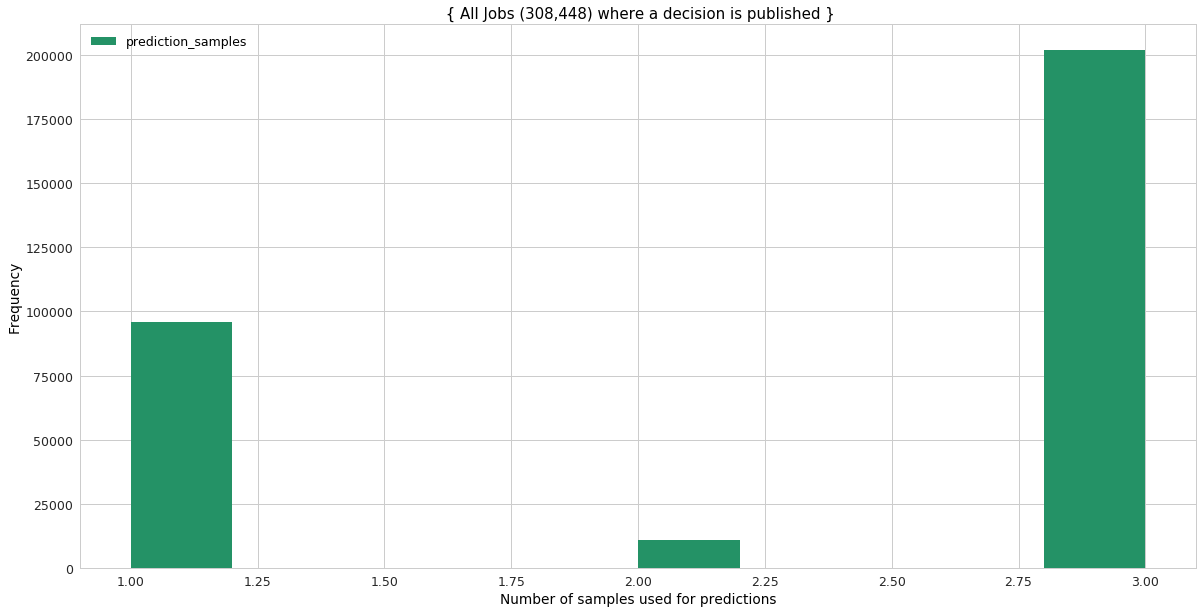

In [63]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.set_title(' { All Jobs (308,448) where a decision is published }')
ax.set_xlabel('Number of samples used for predictions')
decision_df[ [ 'prediction_samples'] ].plot.hist(by="prediction_samples", bins=10, ax=ax, fig=fig)

In [64]:
decision_df.columns

Index(['jobID', 'totaljobduration', 'predictionduration', 'localsamplefrac',
       'noofheartbeats', 'decision_threshold', 'truelabel', 'predictedlabel',
       'prediction_samples'],
      dtype='object')

## Histogram: of incorrect predictions (how many samples were used)

In [65]:
incorrect_df = decision_df[ decision_df['truelabel'] != decision_df['predictedlabel']]

In [66]:
#Verification
len(incorrect_df)

46458

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


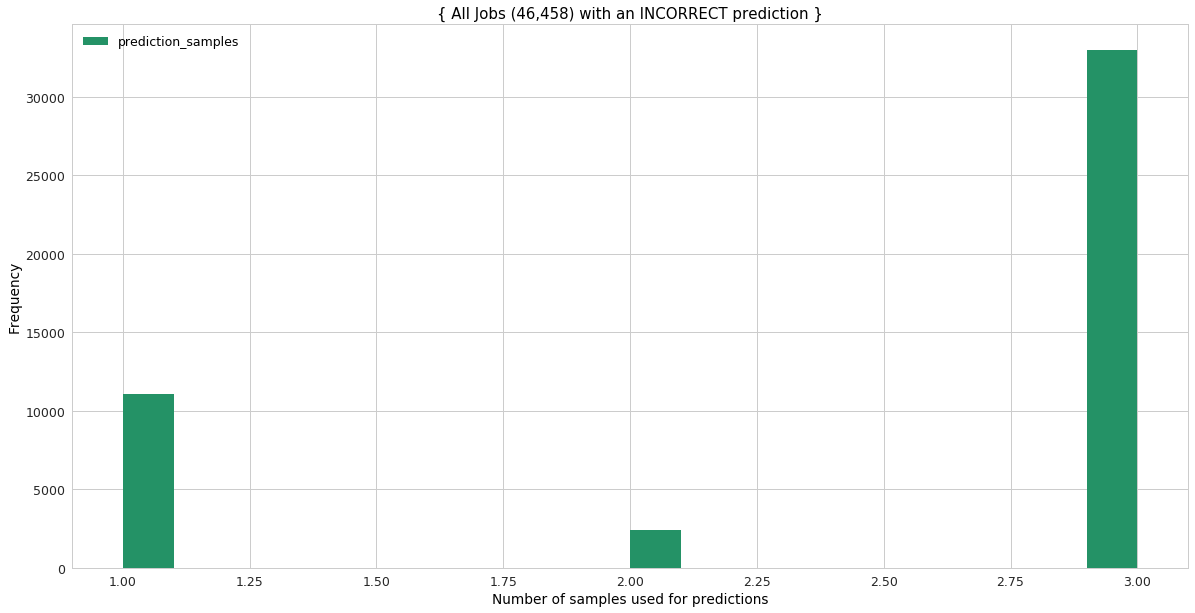

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.set_xlabel('Number of samples used for predictions')
ax.set_title('{ All Jobs (46,458) with an INCORRECT prediction }')
incorrect_df[ [ 'prediction_samples'] ].plot.hist(by="prediction_samples", bins=20, ax=ax, fig=fig)

## Histogram: of "correct" predictions (how many samples were used)

In [68]:
correct_df = decision_df[ decision_df['truelabel'] == decision_df['predictedlabel']]

In [69]:
#Verification
len(correct_df)

261990

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['Verdana'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


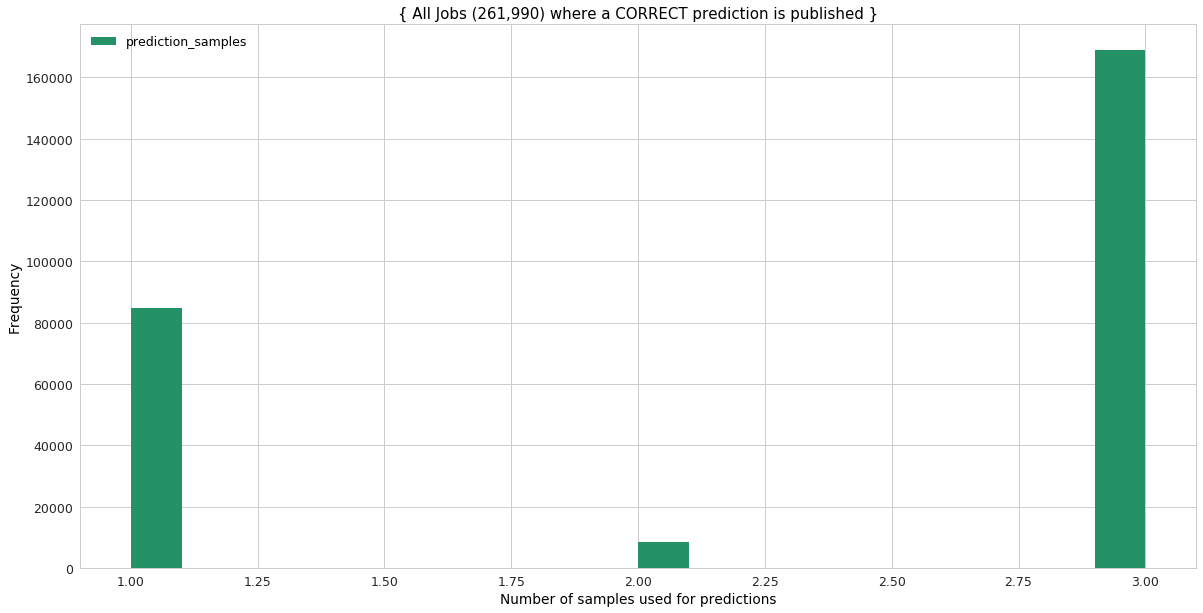

In [70]:
fig, ax = plt.subplots(1, 1, figsize=(20,10))
ax.set_xlabel('Number of samples used for predictions')
ax.set_title('{ All Jobs (261,990) where a CORRECT prediction is published }')
correct_df[ [ 'prediction_samples'] ].plot.hist(by="prediction_samples", bins=20, ax=ax, fig=fig)